# SITCOM-1136 - M1M3 - analyze position and rotation stability throughout a tracking period

2023-12-14 Laura

This notebook evaluates displacements of M1M3 for X, Y, Z, RX, RY, and RZ during the period beteween slews while tracking (approximately 30 s) and check if they comply with the 2 micron and 2e-5 degree requirement.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

from scipy import stats 

In [3]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

### Define relevant settings

#### Requirements

In [4]:
req_rms_position = 2e-3 ## mm, tolerance from repeatability requirement for IMS positional
req_rms_rotation = 2e-5 ## degrees, tolerance from repeatability requirement for IMS rotational

### Define functions

In [27]:
def computeSettleTrack(
    df_ims,  # input data frame
    tt_start="2023-06-01T06:00:0Z",  # time for slew start
    tt_end = "2023-06-01T06:00:0Z",  # time for track stop
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    delta_t=5,
    seqNum=000
):
    if "Position" in imsColumn:
        units = "mm"
        ylimMax = rmsReq + 0.005
    elif "Rotation" in imsColumn:
        units = "deg"
        ylimMax = rmsReq + 0.00005
    else:
        print("Unidentified column")
        return -1
 
    # Define Times
    T0 = pd.to_datetime(tt_start) - pd.to_timedelta(delta_t, unit="s")
    T1 = pd.to_datetime(tt_end) + pd.to_timedelta(delta_t, unit="s")
    t_track_starts = pd.to_datetime(tt_start)
    t_track_ends = pd.to_datetime(tt_end)
    # We removed 0.1s from the tracking (to eliminate the moment when the telescope starts moving) in order to calculate de RMS in the start and end of the tracking.
    # The RMS is calculated with values close to a specific time of the tracking, in this way we avoid taking velues from the slew
    t_track_starts_check = pd.to_datetime(tt_start) + pd.to_timedelta(0.1, unit="s")
    t_track_ends_check = pd.to_datetime(tt_end) - pd.to_timedelta(0.1, unit="s")

    # Define Target
    # targetVariablePlot takes the data frame for the complete plot range
    targetVariablePlot = df_ims[imsColumn][T0 : T1]
    
    # Define index
    idxT0 = df_ims.index[  # index in dataframe closest in time to start of plot
        df_ims.index.get_indexer([pd.to_datetime(t_track_starts)+ pd.to_timedelta(10, unit="s")], method="nearest")
    ]
    idxT1 = df_ims.index[  # index in dataframe closest in time to + pd.to_timedelta(delta_t, unit="s")end of plot
            df_ims.index.get_indexer([pd.to_datetime(t_track_ends)- pd.to_timedelta(10, unit="s")], method="nearest")
    ] 

    targetVariableReference = [
        float(df_ims[imsColumn][idxT0]),
        float(df_ims[imsColumn][idxT1]),
    ]
    if len(targetVariablePlot.index) == 0:
        print("Data frame is empty")
        return -1
    
    correctedVariablePlot = targetVariablePlot - targetVariableReference[1]

    # Tracking time
    tts_unix = Time(t_track_starts).unix
    tte_unix = Time(t_track_ends).unix
    seconds = tte_unix - tts_unix
    seconds_decimal = round(seconds,2)

    # Check stability
    filtered_correctedVariablePlot = correctedVariablePlot.loc[t_track_starts_check:t_track_ends_check]
    
    # rms
    rolling = 10  # 50 is approx. 1 s
    rms = filtered_correctedVariablePlot.rolling(rolling).std()
    
    # Plot
    title = f"Tracking time: {seconds_decimal} seconds. SeqNum:" '{:.2f}'.format(seqNum)
    fig = plt.figure()
    label = "Corrected " + imsColumn + "(" + units + ") difference wrt end of plot"
    plt.title(title)    
    
    plt.plot(
            correctedVariablePlot,
            color="red",
            ls="dashed",
            lw="0.5",
            label=label,
    )

    plt.plot(rms, lw=1.2, c='blue', label="RMS") 
        
    plt.axhline(-rmsReq, lw="0.75", c="k", ls="dashed", label=f"IMS repeatability req.")
    plt.axhline(rmsReq, lw="0.75", c="k", ls="dashed")
    plt.axvline(x=t_track_starts, color='black', linestyle='dashed', linewidth=1.2, label='Start of Tracking')
    plt.axvline(x=t_track_ends, color='black', linestyle='dashed', linewidth=1.2, label='End of Tracking')
    plt.axvspan(t_track_starts, t_track_starts + pd.to_timedelta(3, unit="s"), color='lightblue', alpha=0.5, label='settling time? 3s')

    division = seconds / 5.
    plt.xticks([t_track_starts, t_track_starts + pd.to_timedelta(division, unit="s") ,
                t_track_starts + pd.to_timedelta(2*division, unit="s"),
                t_track_starts + pd.to_timedelta(3*division, unit="s"),
                t_track_starts + pd.to_timedelta(4*division, unit="s"),
                t_track_ends], 
               [0, round(division,2), round(2*division,2), round(3*division,2) , round(4*division,2),round((tte_unix - tts_unix), 2)])


    
    plt.xlabel("Time [UTC]")
    plt.ylabel(f"{imsColumn} {units}")
    plt.ylim(-ylimMax, ylimMax)
    fig.autofmt_xdate()
    plt.legend(loc="upper right", fontsize="8")
    fig.tight_layout()


In [6]:
def detectUnstableEvents(
    df_ims,  # input data frame
    tt_start="2023-06-01T06:00:0Z",  # time for slew start
    tt_end = "2023-06-01T06:00:0Z",  # time for track stop
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    delta_t=5
):
    if "Position" in imsColumn:
        units = "mm"
        ylimMax = rmsReq + 0.005
    elif "Rotation" in imsColumn:
        units = "deg"
        ylimMax = rmsReq + 0.00005
    else:
        print("Unidentified column")
        return -1
 
    # Define Times
    T0 = pd.to_datetime(tt_start) - pd.to_timedelta(delta_t, unit="s")
    T1 = pd.to_datetime(tt_end) + pd.to_timedelta(delta_t, unit="s")
    t_track_starts = pd.to_datetime(tt_start)
    t_track_ends = pd.to_datetime(tt_end)
    # We removed 0.1s from the tracking check to eliminate the moment when the telescope starts moving.
    t_track_starts_check = pd.to_datetime(tt_start) + pd.to_timedelta(0.1, unit="s")
    t_track_ends_check = pd.to_datetime(tt_end) - pd.to_timedelta(0.3, unit="s")


    
    # Define Target
    targetVariablePlot = df_ims[imsColumn][T0 : T1]
    
    # Define index
    idxT0 = df_ims.index[  # index in dataframe closest in time to start of plot
        df_ims.index.get_indexer([pd.to_datetime(t_track_starts)+ pd.to_timedelta(10, unit="s")], method="nearest")
    ]
    idxT1 = df_ims.index[  # index in dataframe closest in time to + pd.to_timedelta(delta_t, unit="s")end of plot
            df_ims.index.get_indexer([pd.to_datetime(t_track_ends)- pd.to_timedelta(10, unit="s")], method="nearest")
    ] 

    targetVariableReference = [
        float(df_ims[imsColumn][idxT0]),
        float(df_ims[imsColumn][idxT1]),
    ]
    if len(targetVariablePlot.index) == 0:
        print("Data frame is empty")
        return -1
    
    correctedVariablePlot = targetVariablePlot - targetVariableReference[1]

    tts_unix = Time(t_track_starts).unix
    tte_unix =  Time(t_track_ends).unix
    time = tte_unix - tts_unix

    
    if time < 2:
        #print("Warning: tracking duration less than 2 seconds")
        return -1
        
    # Check stability
    filtered_correctedVariablePlot = correctedVariablePlot.loc[t_track_starts_check:t_track_ends_check]
    
    # rms
    rolling = 10  # 50 is approx. 1 s
    rms = filtered_correctedVariablePlot.rolling(rolling).std()
    
    for valor in rms:
      if valor > rmsReq:
        #print("Warning! Telescope movement during tracking exceeds the required rms limits")
        return -2
        break  
     
    return +1

### Definition of case

#### Observation day

In [7]:
dayObs = 20231220  #20231129 20231222 

In [20]:
## Define column names
# To study all particular cases comment and uncommet the 
all_columns = [
    "xPosition",
    #"yPosition",
    #"zPosition",
    #"xRotation",
    #"yRotation",
    #"zRotation",
]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [9]:
delta_t = 5

#### Get slew stops

In [10]:
# Select data from a given date
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 549 slews and 234 tracks


In [11]:
# Get events related to soak tests (block 146 currently)
block146Events = []
for event in events:
    blockInfos = event.blockInfos
    if blockInfos is None:
        continue  # no block info attached to event at all

    # check if any of the attached blockInfos are for block 146
    blockNums = {b.blockNumber for b in blockInfos}
    if 146 in blockNums:
        block146Events.append(event)

print(f"Of the {len(events)} events, {len(block146Events)} relate to block 146.")

Of the 783 events, 454 relate to block 146.


In [12]:
# Print out sequential number of events that have certain characteristics
t = 0
tracks_block146 = []
for i in range(len(block146Events)):
    if (
        block146Events[i].endReason == TMAState.SLEWING
        and block146Events[i].type == TMAState.TRACKING
    ):
        #print(block146Events[i].seqNum, " ", block146Events[i].duration)
        t = t + 1
        print(block146Events[i].seqNum, end=", ")
        tracks_block146.append(block146Events[i])

93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 275, 277, 279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 367, 369, 371, 373, 375, 377, 379, 381, 383, 385, 387, 389, 391, 393, 395, 397, 399, 401, 403, 405, 407, 409, 411, 413, 415, 417, 419, 421, 423, 425, 427, 429, 431, 433, 435, 437, 439, 441, 443, 445, 447, 449, 451, 453, 455, 457, 459, 461, 463, 465, 467, 469, 471, 473, 475, 477, 479, 481, 483, 485, 487, 489, 491, 493, 495, 497, 499, 501, 503,

In [13]:
# Number of TRACKING in block 146
print(f"Of the {len(block146Events)} events of block 146, {t} are trackings.")

Of the 454 events of block 146, 226 are trackings.


In [14]:
## Time of the tracking:

# Get durations of the tracking
durations = [track.duration for track in tracks_block146]

# Calculate mean, standard deviation, and variance
mean_duration = np.mean(durations)
standard_deviation = np.std(durations)
variance = np.var(durations)
median_duration = np.median(durations)

# Round the durations for mode calculation
rounded_durations = [round(track.duration) for track in tracks_block146]

# Calculate mode of rounded durations
mode_duration = stats.mode(rounded_durations)


# Print the results
print("Number of trackings:", len(durations))
print("Mean duration of tracking:", mean_duration)
print("Median duration of tracking:", median_duration)
print("Mode of tracking duration (rounded):", mode_duration.mode[0])
print("Standard deviation of tracking duration:", standard_deviation)
print("Variance of tracking duration:", variance)
print("Maximum duration of tracking:", np.max(durations))
print("Minimum duration of tracking:", np.min(durations))


# Create a boxplot using seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(y=durations, width=0.5)
plt.title('Boxplot of Tracking Duration')
plt.ylabel('Duration (s)')
plt.show()

# Create a boxplot using seaborn (zoom)
plt.figure(figsize=(8, 6))
sns.boxplot(y=durations, width=0.5)
plt.ylim(np.percentile(durations, 7), np.percentile(durations, 93))
plt.title('Zoomed Boxplot of Tracking Duration')
plt.ylabel('Duration (s)')
plt.show()


Number of trackings: 226
Mean duration of tracking: 53.15725511998202
Median duration of tracking: 42.11979269981384
Mode of tracking duration (rounded): 42
Standard deviation of tracking duration: 98.32073054731215
Variance of tracking duration: 9666.966055357161
Maximum duration of tracking: 929.5563025474548
Minimum duration of tracking: 0.39732980728149414


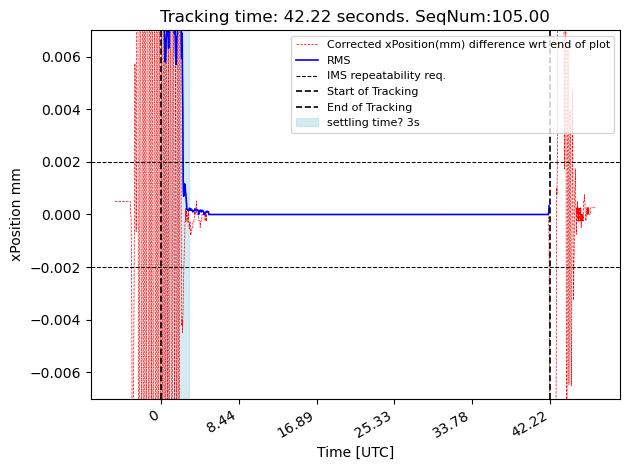

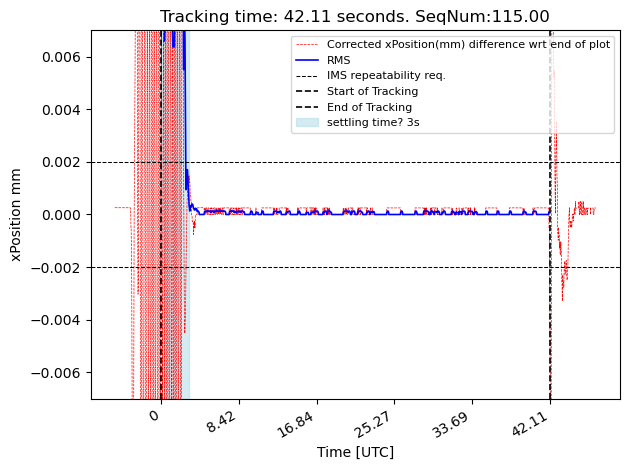

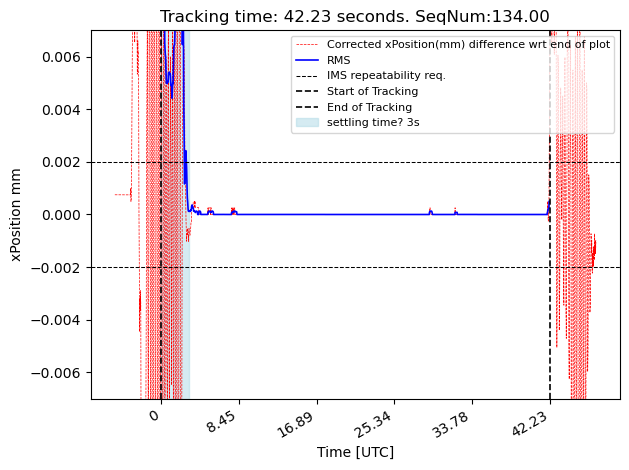

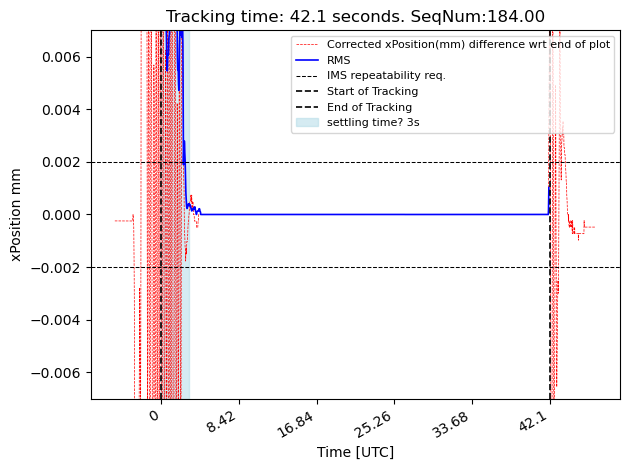

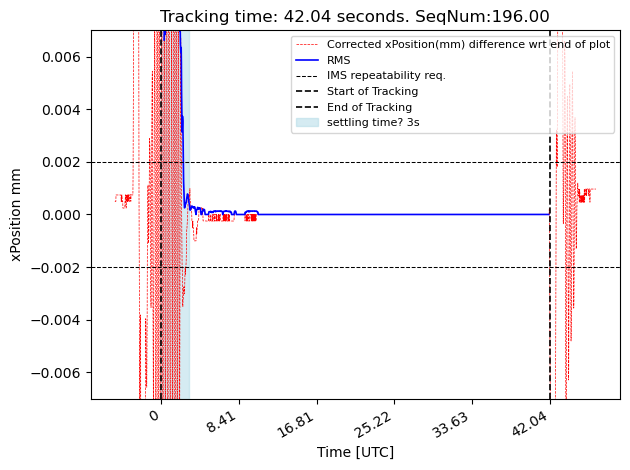

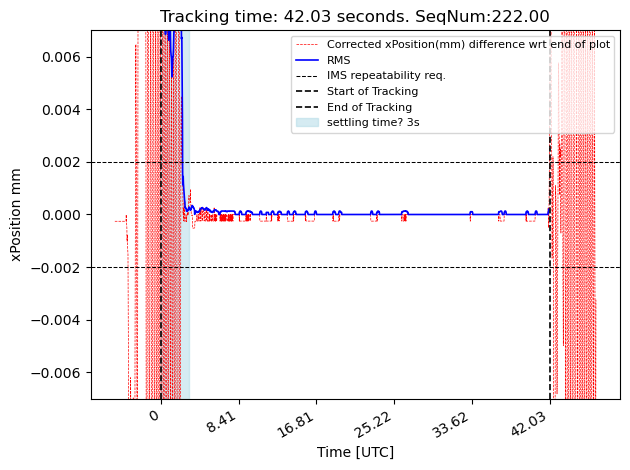

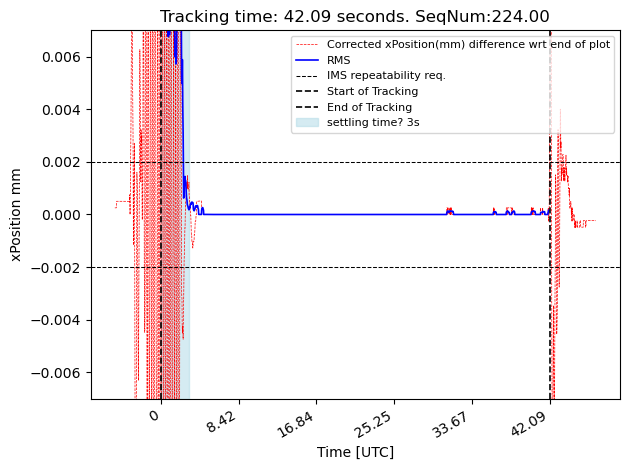

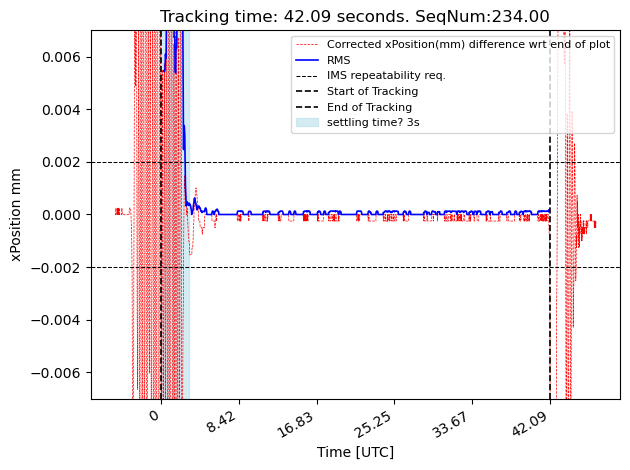

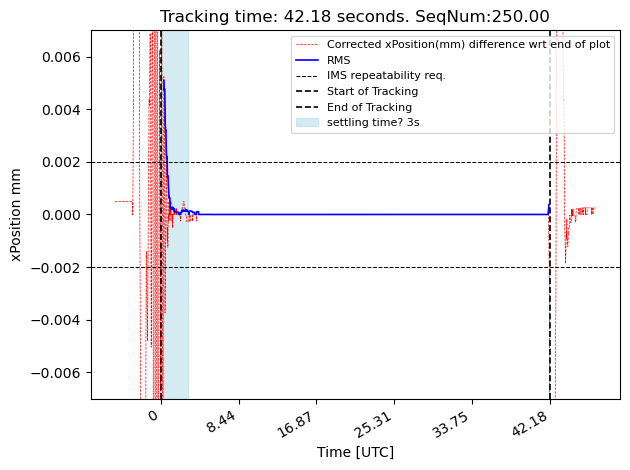

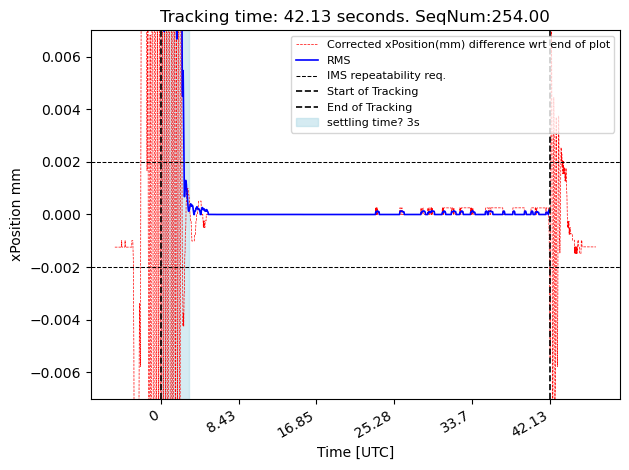

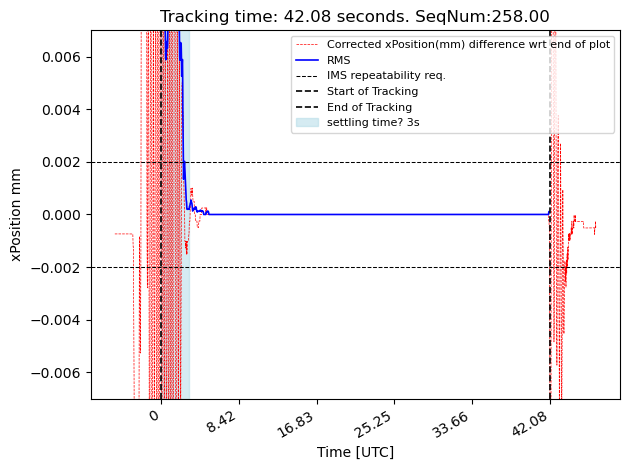

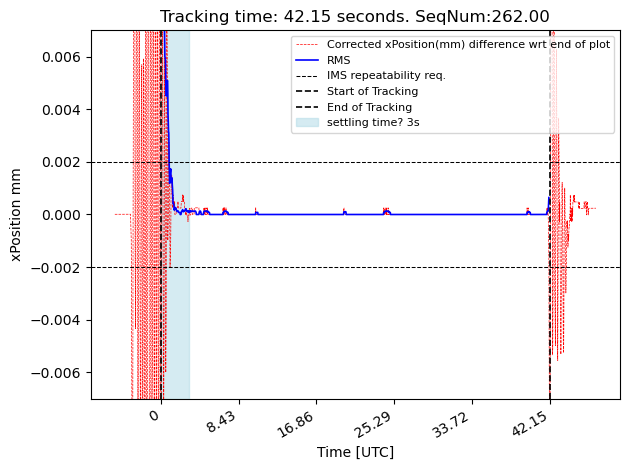

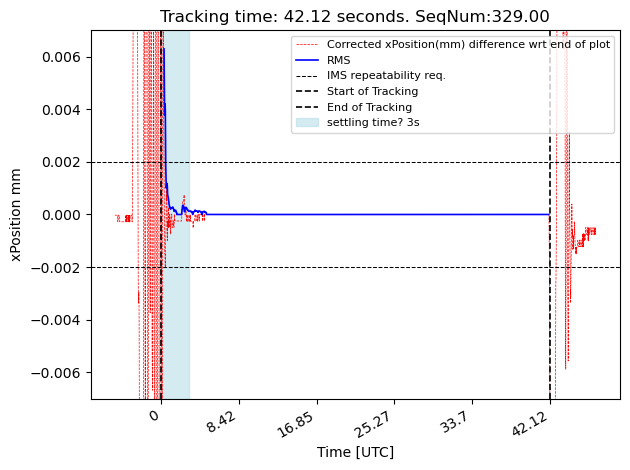

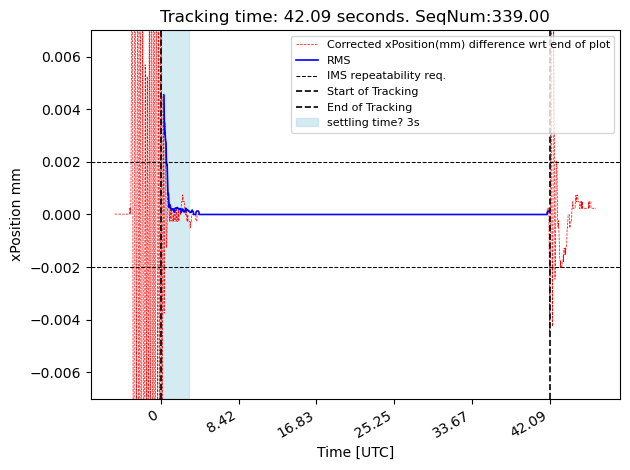

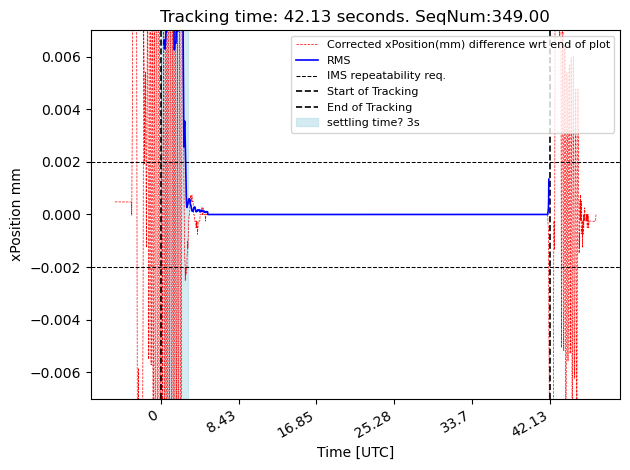

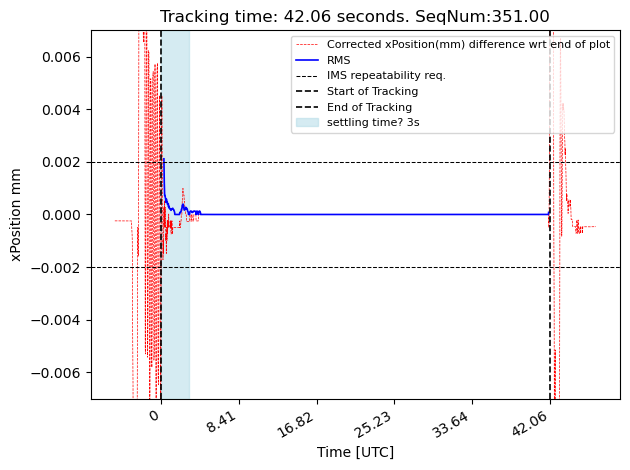

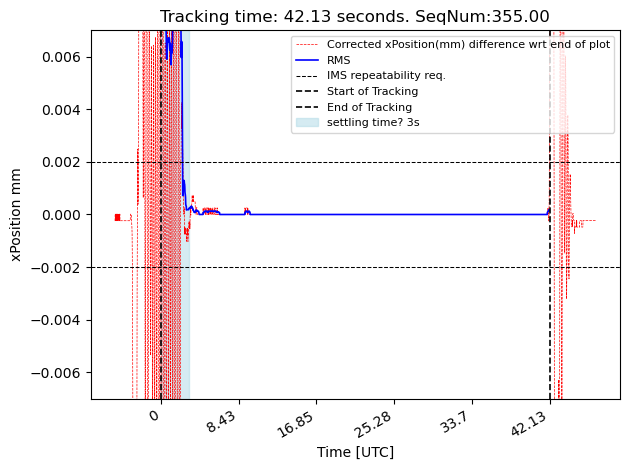

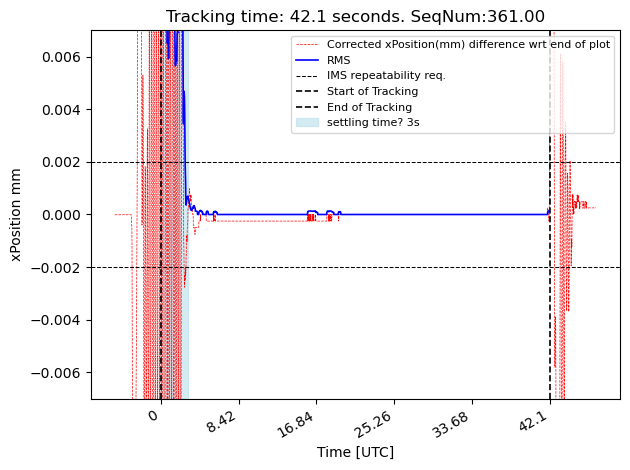

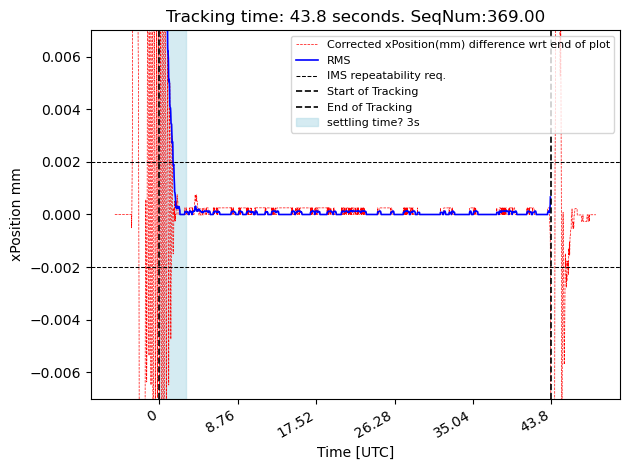

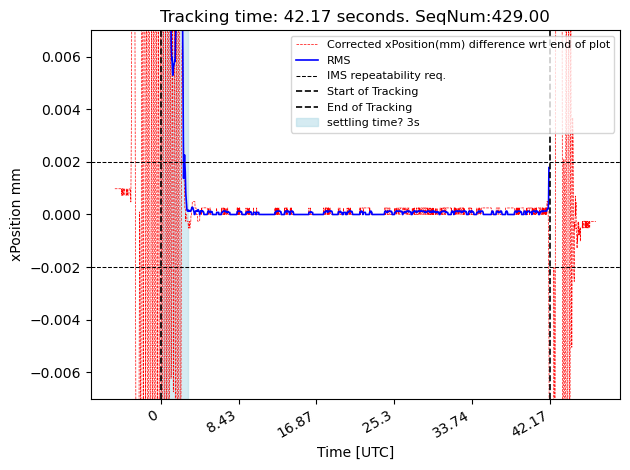

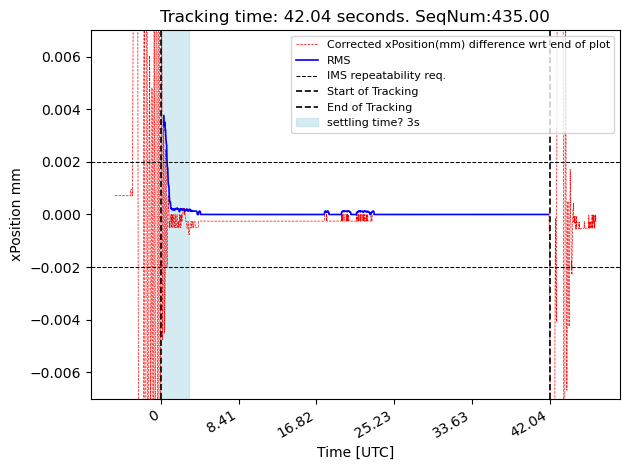

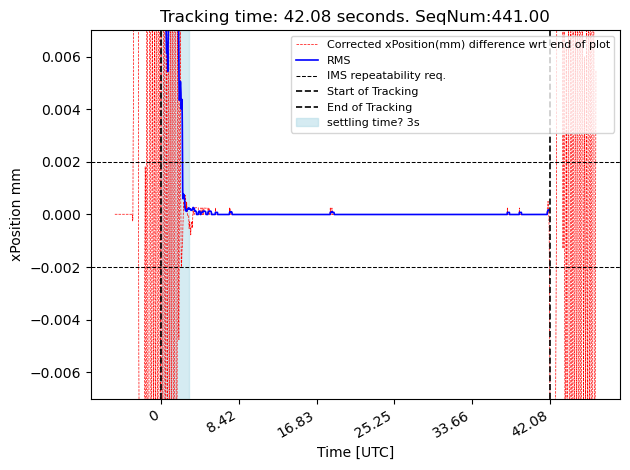

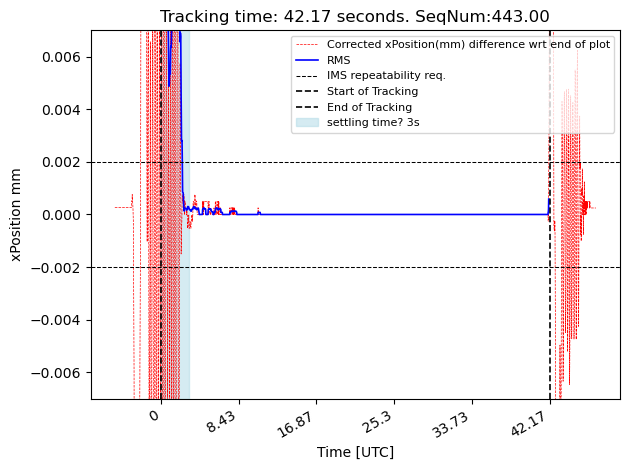

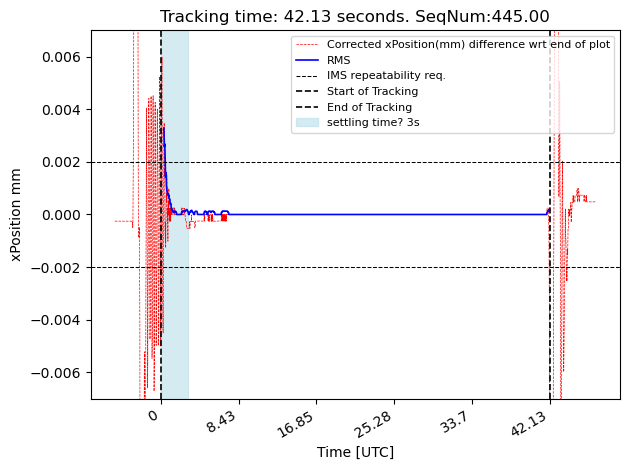

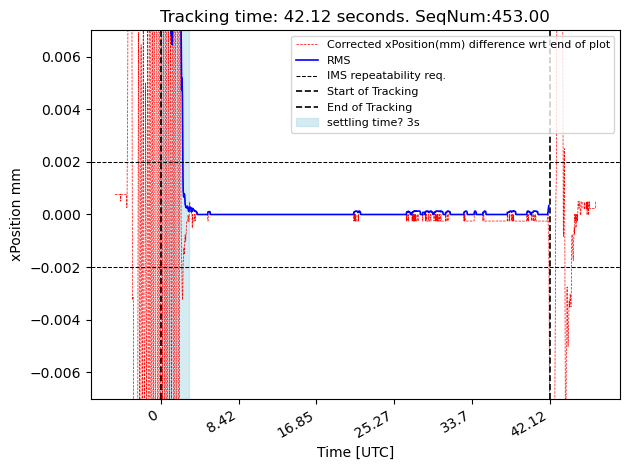

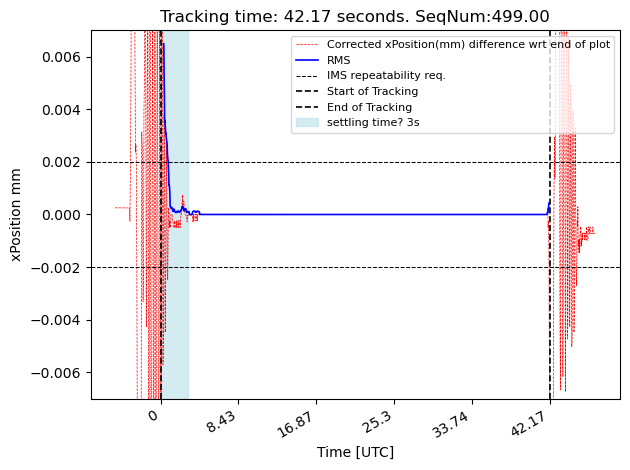

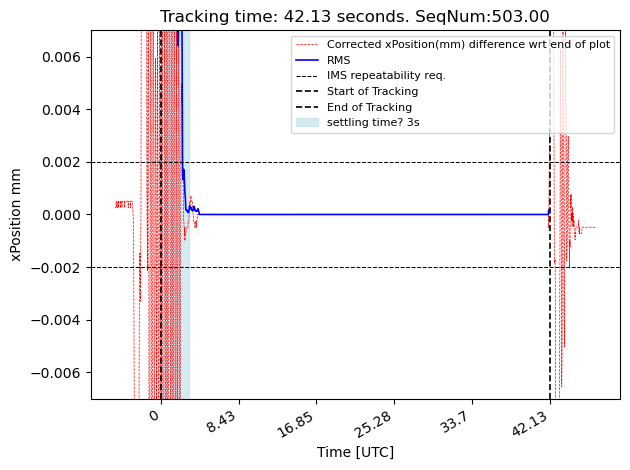

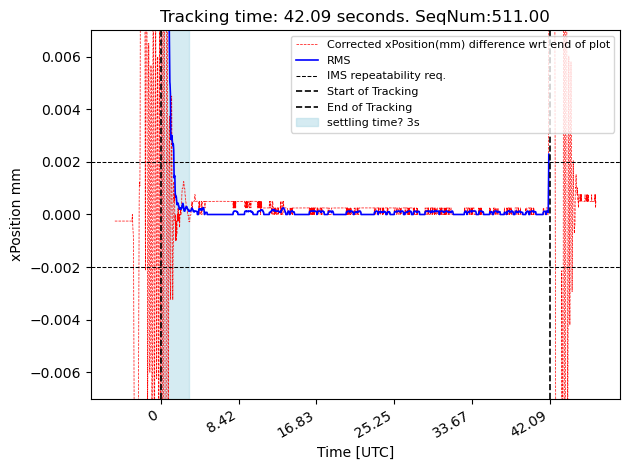

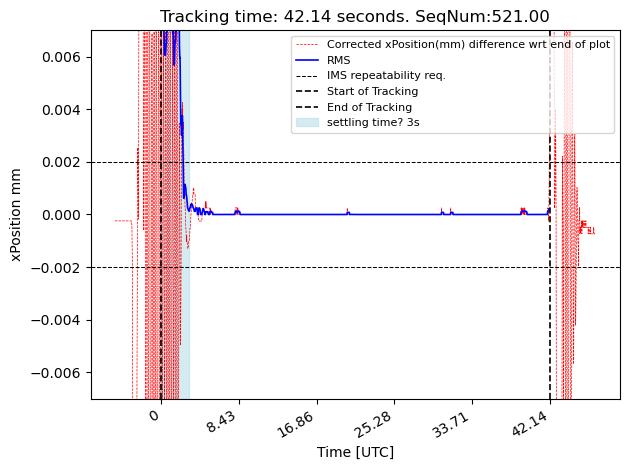

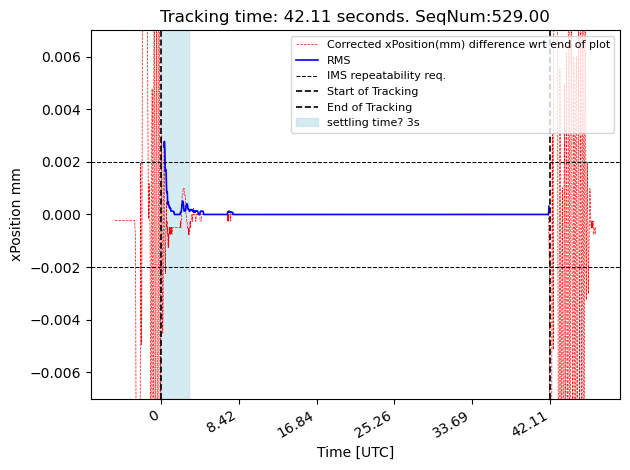

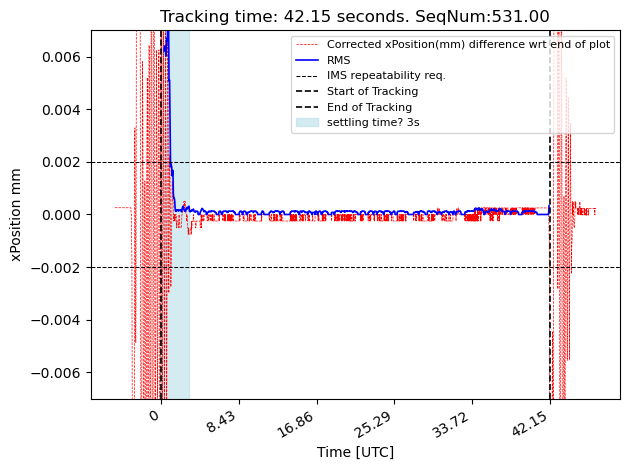

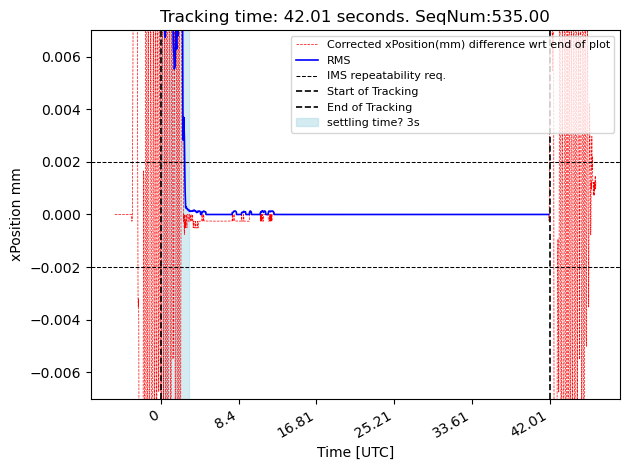

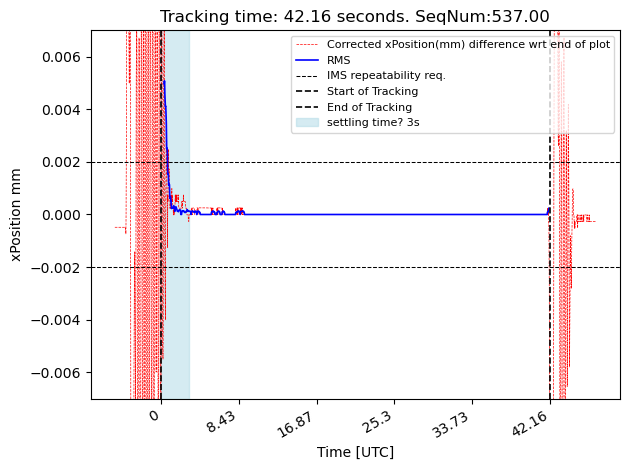

In [28]:
unstable_events = {}
outRMSLimits_event = []
for event in enumerate(tracks_block146):
    targetSeqNum = event[1].seqNum
    is_unstable = False
    unstable_reason = "stable"
    #print(targetSeqNum)
    for t, tl in enumerate(tracks):
        if tl.seqNum == targetSeqNum:
            #print("tracking number seq Num: ", targetSeqNum)
            i_track = t

            # Select the information during the tracking
            t0 = Time(tracks[i_track].begin, format="isot", scale="utc")
            t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
            t1 = Time(tracks[i_track].end, format="isot", scale="utc")
            t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion
            #print("Tracking stop at:", t1)
            
            # Get IMS data
            df_ims = getEfdData(
                     client, "lsst.sal.MTM1M3.imsData", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
            df_ims = df_ims[all_columns]
            # Convert meter to milimeter
            df_ims[pos_columns] = df_ims[pos_columns] * 1e3
            
            #df_mtmount_ele = getEfdData(
            #client, "lsst.sal.MTMount.elevation", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)

            #df_mtmount_azi = getEfdData(
            #client, "lsst.sal.MTMount.azimuth", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
            
            #stability throughout a tracking period
            %matplotlib inline
            
            settle_intervals = np.empty(6)
            c = 0.

            for col in all_columns:
                if col in pos_columns:
                   req = req_rms_position
                else:
                   req = req_rms_rotation

                Unstable = detectUnstableEvents(
                           df_ims=df_ims,
                           tt_start=t0,
                           tt_end=t1,        
                           imsColumn=col,
                           rmsReq=req,
                           delta_t=5
                           )
                
                if Unstable == -1:
                   is_unstable = True
                   unstable_reason = "sortTime"
                   break
                if Unstable == -2:
                   is_unstable = True
                   unstable_reason = "outRMSLimits"
                   outRMSLimits_event.append(targetSeqNum)
                   break

    unstable_events[targetSeqNum] = {"is_unstable": is_unstable, "reason": unstable_reason}  

    if unstable_reason == "outRMSLimits": #"outRMSLimits":
        
        for col in all_columns:
                if col in pos_columns:
                   req = req_rms_position
                else:
                   req = req_rms_rotation 
                    
                settle_interval = computeSettleTrack(
                   df_ims=df_ims,
                   tt_start=t0,
                   tt_end=t1,        
                   imsColumn=col,
                   rmsReq=req,
                   #req_delta_t=req_delta_t,
                   #chi2prob=0.99,
                   delta_t=5,
                   seqNum=targetSeqNum
                   )   
                

In [16]:
count_is_unstable = {"True": sum(event["is_unstable"] for event in unstable_events.values()),
               
                     "False": sum(not event["is_unstable"] for event in unstable_events.values())}
print(count_is_unstable)

{'True': 37, 'False': 189}


In [17]:
from collections import Counter
count_reason = [event["reason"] for event in unstable_events.values()]

print(Counter(count_reason))

Counter({'stable': 189, 'outRMSLimits': 34, 'sortTime': 3})


## Tracking duration

In [18]:
dayObs = 20231220

# Select data from a given date
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

# Get events related to soak tests (block 146 currently)
block146Events = []
for event in events:
    blockInfos = event.blockInfos
    if blockInfos is None:
        continue  # no block info attached to event at all

    # check if any of the attached blockInfos are for block 146
    blockNums = {b.blockNumber for b in blockInfos}
    if 146 in blockNums:
        block146Events.append(event)

print(f"Of the {len(events)} events, {len(block146Events)} relate to block 146.")

# Print out sequential number of events that have certain characteristics
t = 0
tracks_block146 = []
for i in range(len(block146Events)):
    if (
        block146Events[i].endReason == TMAState.SLEWING
        and block146Events[i].type == TMAState.TRACKING
    ):
        print(block146Events[i].seqNum, " ", block146Events[i].duration)
        t = t + 1
        #print(block146Events[i].seqNum, end=", ")
        tracks_block146.append(block146Events[i])

# Number of TRACKING in block 146
print(f"Of the {len(block146Events)} events of block 146, {t} are trackings.")

Found 549 slews and 234 tracks
Of the 783 events, 454 relate to block 146.
93   0.39732980728149414
95   42.126830101013184
97   42.17957520484924
99   42.16201829910278
101   42.06141710281372
103   42.19040846824646
105   42.22498345375061
107   42.122339725494385
109   42.17466497421265
111   42.0978262424469
113   42.090951681137085
115   42.109912395477295
117   42.15677833557129
119   42.231752157211304
121   42.2232232093811
128   0.40500402450561523
130   42.10776400566101
132   42.20077443122864
134   42.225672006607056
136   929.4198627471924
138   42.05197858810425
140   42.197157859802246
142   42.08982300758362
144   42.11864113807678
146   42.10337042808533
148   42.07976984977722
150   42.10764718055725
152   42.101181983947754
154   42.12395453453064
156   42.052743434906006
158   42.14133381843567
160   42.10778045654297
162   42.118359088897705
164   42.14553165435791
166   42.02168035507202
168   42.226789236068726
170   42.109105825424194
172   42.02995491027832
174